Imports

In [1]:
import os
import scipy as sp
import numpy as np
import time
from matplotlib import pyplot as plt
from stereoid.oceans.forward_models import SAR_spectra as SAR_model
from stereoid.instrument import ObsGeo
import drama.geo as sargeo
from pylab import figure, cm
from matplotlib.colors import LogNorm
from stereoid.oceans.waves.wave_spectra import elfouhaily
from stereoid.oceans.waves.wave_spectra import elfouhaily_spread

# output folder
outpath='/Users/marcelmac/Documents/Papers/BistaticSARtransform/'

# Run ID
mode = "IWS"
run_id='2021_1'

# stereoid path
path='/Users/marcelmac//Data/Harmony'
pardir=path + '/PAR/'
parfile=pardir + 'Hrmny_' + run_id + '.cfg'
main_dir=path + ''

Set some geometry

In [2]:
# Incident angle
incm = np.deg2rad(35)
along_track_separation=350E3 # should be consistent with the PAR file
swth_bst = sargeo.SingleSwathBistatic(par_file=parfile, dau=along_track_separation)
# Observation geometry calculated from orbit
obsgeo = ObsGeo.from_swath_geo(incm, swth_bst, ascending=True)
# receiver/transmitter range
Ix=np.argmin(np.absolute(incm-np.degrees(swth_bst.master_inc[0,:])))
Rt=swth_bst.master_range[0,Ix]
Rr=swth_bst.slave_range[0,Ix]
# angles
bist_ang=obsgeo.bist_ang
inc_m=obsgeo.inc_m
inc_b=obsgeo.inc_b
# rotation angle for MACS and cut-off
alpha_rot=np.arctan(np.sin(bist_ang)*np.sin(inc_b)/(np.sin(inc_m)+ np.cos(bist_ang)*np.sin(inc_b)))

Make a spectrum

In [3]:
# wave numbers in a Cartesian grids (kx=cross,ky=along)
g = 9.81
scene_size = 5000  # maximum wavelength (size of image)
dx = 5
dy = 5
Nx=int(scene_size/dx)
Ny=int(scene_size/dy)
kx = np.ones( (1, Nx) )
ky = np.ones( (Ny, 1) )
dk = 2 * np.pi / scene_size  # fundamental frequency
kx[ 0, 0:int( Nx / 2 ) ] = dk * np.arange( 0, Nx / 2 )
kx[ 0, int( Nx / 2 ): ] = dk * np.arange( -Nx / 2, 0 )
kx = np.dot( np.ones( (Ny, 1) ), kx )
ky[ 0:int( Ny / 2 ), 0 ] = dk * np.arange( 0, Ny / 2 )
ky[ int( Ny / 2 ):, 0 ] = dk * np.arange( -Ny / 2, 0 )
ky = np.dot( ky, np.ones( (1, Nx) ) )
k = np.sqrt( kx ** 2 + ky ** 2 )
omega = np.sqrt( g * k )  # angular velocity
phi = np.arctan2( ky, kx )  # 0 is cross-track direction waves, 90 along-track
shp=k.shape

Compute variances

243.9546862080458
2.0919966410537643


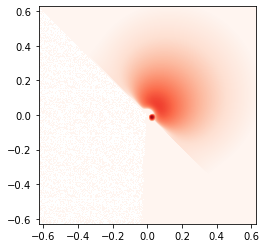

In [4]:
MTF='Kirchhoff'

# wind-wave spectrum
phi_w = np.deg2rad(45)
u10 = 10
IWA = 1.0

# compute fetch from inverse wave age
X_0 = 22E3
X = np.arctanh( (IWA / 0.84) ** (-1 / 0.75) ) ** (1 / 0.4) * X_0
k_0 = g / u10 ** 2
fetch = X / k_0

# compute wave-spectrum spectrum
Sp = elfouhaily( k, u10, fetch )
dphi = (phi_w - phi + np.pi) % (2 * np.pi) - np.pi  # including unwrapping
D = elfouhaily_spread( k, dphi, u10, fetch )
S = Sp * D / k
S[ 0, 0 ] = 0

# swell spectrum
phi_s=np.deg2rad(-30) # wave direction
f_p=0.08 # peak frequency
sigma_f=0.007 # spread in frequency
sigma_phi=np.deg2rad(10) # spreadk in direction
Hs=1 # significant wave height
k_p=(f_p*2*np.pi)**2/g
lambda_p=(2*np.pi)/k_p
print(lambda_p)

# frequency spectrum
f=0.5/np.pi*np.sqrt(g*k)
fac_f=0.25/np.pi*np.sqrt(g/k)
amp=(Hs/4)**2/(sigma_f*np.sqrt(2*np.pi))
Sp=(amp*np.exp(-(f-f_p)**2/(2*sigma_f**2)) + 1E-5) * fac_f

# directional distribution
dphi = (phi_s-phi + np.pi) % (2 * np.pi) - np.pi # including unwrapping
D=np.exp(-dphi**2/(2*sigma_phi**2))/(2*np.pi*sigma_phi**2)**0.5 # directional component

# two dimensional spectrum
S=S+Sp*D/k
S[0,0]=0

plt.imshow(np.fft.fftshift(S),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap='Reds', origin='lower',norm=LogNorm(vmin=0.01, vmax=1000))
print(np.sqrt(np.sum(S*dk*dk))*4)

# scaling for input into fft (2*pi-scaling inside of the correlation functions)
S=S*dk*dk*Nx*Ny

# get cross-correlations
wn_grid={"S": S,"k_x": kx,"k_y": ky}
T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_m, np.radians(0.0001), mtf = MTF )
II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_m, np.radians(0.0001), Rt, Rt )
G = (1 + II)
Pm = np.fft.fft2(G)*dx*dy
Pm[0,0]=0

T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, bist_ang, mtf = MTF )
II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, bist_ang, Rt, Rr )
G = (1 + II)
Pf = np.fft.fft2(G)*dx*dy
Pf[0,0]=0
            
T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, -bist_ang, mtf = MTF )
II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, -bist_ang, Rt, Rr )
G = (1 + II)
Pb = np.fft.fft2(G)*dx*dy
Pb[0,0]=0

Plots

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_25936/2914821517.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('gist_ncar_r', 15)
/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_25936/2914821517.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2=cm.get_cmap('Reds', 15)


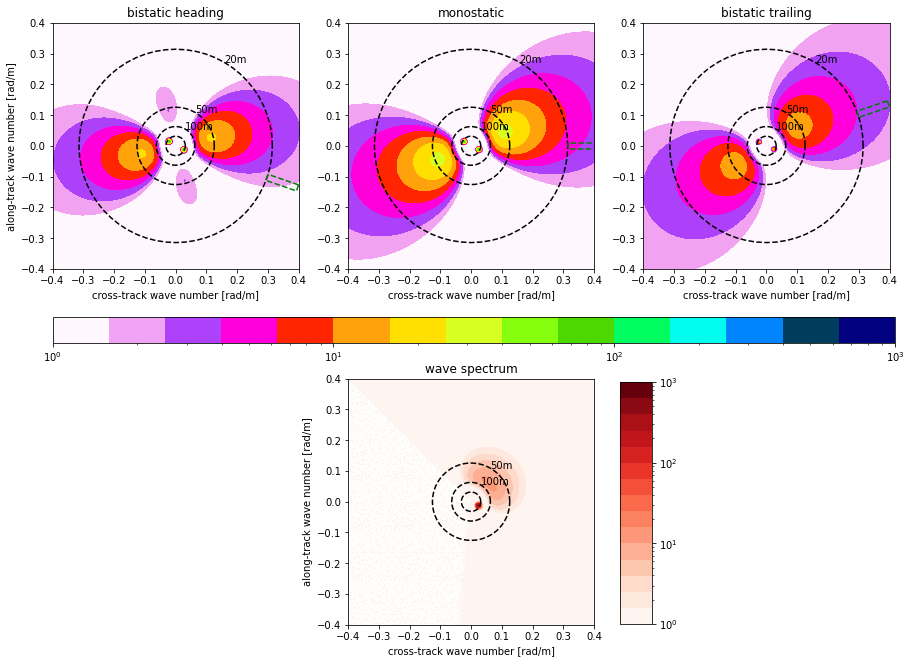

In [10]:
ky_macs=np.array([2*np.pi/15,2*np.pi/20,2*np.pi/20,2*np.pi/15,2*np.pi/15])
kx_macs=np.array([2*np.pi/600,2*np.pi/600,-2*np.pi/600,-2*np.pi/600,2*np.pi/600])

kx_macs_c=kx_macs*np.cos(alpha_rot)+ky_macs*np.sin(-alpha_rot)
ky_macs_c=ky_macs*np.cos(alpha_rot)-kx_macs*np.sin(-alpha_rot)

kx_macs_d=kx_macs*np.cos(-alpha_rot)+ky_macs*np.sin(alpha_rot)
ky_macs_d=ky_macs*np.cos(-alpha_rot)-kx_macs*np.sin(alpha_rot)

# wavelength circles
k100=2*np.pi/100;
k200=2*np.pi/200;
k50=2*np.pi/50;
k20=2*np.pi/20;
ph=np.linspace(0,2*np.pi,61)
kx20=np.cos(ph)*k20
ky20=np.sin(ph)*k20
kx50=np.cos(ph)*k50
ky50=np.sin(ph)*k50
kx100=np.cos(ph)*k100
ky100=np.sin(ph)*k100
kx200=np.cos(ph)*k200
ky200=np.sin(ph)*k200

plt_lim=0.4
extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky))

fig=plt.figure(figsize=(15,12))
cmap=cm.get_cmap('gist_ncar_r', 15)
# bi-static case (forward)
plt.subplot(2,3,1)
plt.imshow(np.fft.fftshift(np.absolute(Pf)),extent=extent,cmap=cmap, origin='lower',norm=LogNorm(vmin=1, vmax=1E3))
plt.title('bistatic heading')
plt.ylabel('along-track wave number [rad/m]')
plt.xlabel('cross-track wave number [rad/m]')
plt.plot(kx20,ky20,'k--')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.plot(ky_macs_c,kx_macs_c,'g--')
plt.text(kx20[10],ky20[10],'20m',color='k')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
#plt.text(kx200[10],ky200[10],'200m',color='k')
plt.xlim(-plt_lim,plt_lim)
plt.ylim(-plt_lim,plt_lim)

# mono-static case
plt.subplot(2,3,3)
plt.imshow(np.fft.fftshift(np.absolute(Pb)),extent=extent,cmap=cmap, origin='lower',norm=LogNorm(vmin=1, vmax=1E4))
plt.title('bistatic trailing')
plt.xlabel('cross-track wave number [rad/m]')
plt.plot(kx20,ky20,'k--')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.plot(ky_macs_d,kx_macs_d,'g--')
plt.text(kx20[10],ky20[10],'20m',color='k')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
#plt.text(kx200[10],ky200[10],'200m',color='k')
plt.xlim(-plt_lim,plt_lim)
plt.ylim(-plt_lim,plt_lim)

# bi-static case (forward)
plt.subplot(2,3,2)
img=plt.imshow(np.fft.fftshift(np.absolute(Pm)),extent=extent,cmap=cmap, origin='lower',norm=LogNorm(vmin=1, vmax=1E3))
plt.title('monostatic')
#plt.ylabel('along-track wave number [rad/m]')
plt.xlabel('cross-track wave number [rad/m]')
plt.plot(kx20,ky20,'k--')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.plot(ky_macs,kx_macs,'g--')
plt.text(kx20[10],ky20[10],'20m',color='k')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
#plt.text(kx200[10],ky200[10],'200m',color='k')
plt.xlim(-plt_lim,plt_lim)
plt.ylim(-plt_lim,plt_lim)

plt.subplot(2,3,5)
cmap2=cm.get_cmap('Reds', 15)
img2=plt.imshow(np.fft.fftshift(S/(dk*dk*Nx*Ny)),extent=extent,cmap=cmap2, origin='lower',norm=LogNorm(vmin=1, vmax=1E3))
plt.title('wave spectrum')
plt.ylabel('along-track wave number [rad/m]')
plt.xlabel('cross-track wave number [rad/m]')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
#plt.text(kx200[10],ky200[10],'200m',color='k')
plt.xlim(-plt_lim,plt_lim)
plt.ylim(-plt_lim,plt_lim)

# add the colorbars
cbaxes = fig.add_axes([0.125, 0.48, 0.78, 0.03]) 
cb = plt.colorbar(img, cax = cbaxes, orientation='horizontal')
cbaxes = fig.add_axes([0.65, 0.155, 0.03, 0.28]) 
cb = plt.colorbar(img2, cax = cbaxes, orientation='vertical')

plt.savefig(outpath + 'RAR_2D.png',dpi=300)